In [2]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the Dataset
data = {
    'Fertilizer': ['Blend X']*20 + ['Blend Y']*20 + ['Blend Z']*20,
    'Crop': (['Wheat']*5 + ['Corn']*5 + ['Soy']*5 + ['Rice']*5) * 3,
    'Yield': [
        123, 156, 112, 100, 168, 128, 150, 174, 116, 109,
        166, 178, 187, 153, 195, 151, 125, 117, 155, 158, # Blend X
        135, 130, 176, 120, 155, 175, 132, 120, 187, 184,
        140, 145, 159, 131, 126, 167, 183, 142, 167, 168, # Blend Y
        156, 180, 147, 146, 193, 186, 138, 178, 176, 190,
        185, 206, 188, 165, 188, 175, 173, 154, 191, 169  # Blend Z
    ]
}
df = pd.DataFrame(data)
df.head()

,Fertilizer,Crop,Yield
0,Blend X,Wheat,123
1,Blend X,Wheat,156
2,Blend X,Wheat,112
3,Blend X,Wheat,100
4,Blend X,Wheat,168


## Hypotheses

**Fertilizer $\times$ Crop**
* **Null Hypothesis ($H_0$):** There is no significant interaction effect between fertilizer type and crop type on yield. (The effect of the fertilizer is consistent across all crops).
* **Alternative Hypothesis ($H_1$):** There is a significant interaction effect between fertilizer type and crop type on yield. (The effectiveness of the fertilizer depends on the crop type).

**Fertilizer**
* **$H_0$:** There is no significant difference in mean yield among the three fertilizer blends.
* **$H_1$:** There is a significant difference in mean yield among the three fertilizer blends.

**Crop**
* **$H_0$:** There is no significant difference in mean yield among the four crop types.
* **$H_1$:** There is a significant difference in mean yield among the four crop types.

---

## Checking Assumptions

**Assumption #1:** The **dependent variable** should be measured at the **continuous** level (i.e., interval or ratio variables).

**Assumption #2:** The **two independent variables** should each consist of **two or more categorical, independent groups**.

**Assumption #3:** There should be **independence of observations**, meaning there is no relationship between the observations in each group or between the groups themselves.

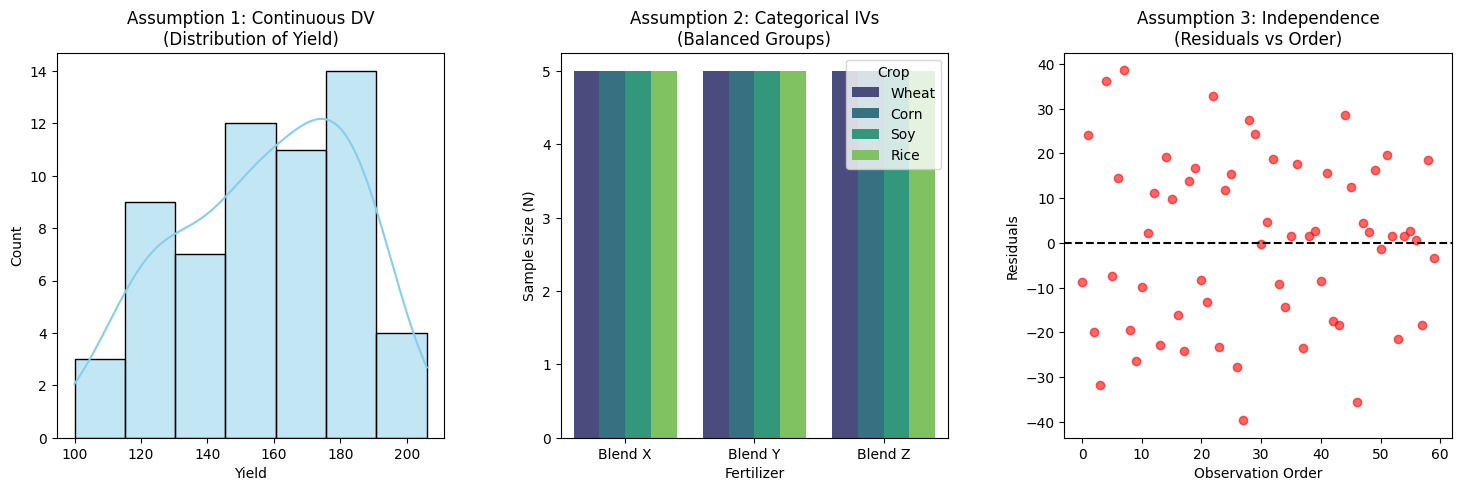

In [3]:
model_temp = ols('Yield ~ C(Fertilizer) + C(Crop) + C(Fertilizer):C(Crop)', data=df).fit()
residuals = model_temp.resid

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(df['Yield'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Assumption 1: Continuous DV\n(Distribution of Yield)')
axes[0].set_xlabel('Yield')

sns.countplot(x='Fertilizer', hue='Crop', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Assumption 2: Categorical IVs\n(Balanced Groups)')
axes[1].set_ylabel('Sample Size (N)')

axes[2].scatter(range(len(residuals)), residuals, alpha=0.6, color='red')
axes[2].axhline(y=0, color='black', linestyle='--')
axes[2].set_title('Assumption 3: Independence\n(Residuals vs Order)')
axes[2].set_ylabel('Residuals')
axes[2].set_xlabel('Observation Order')

plt.show()

**Assumption #4:** There should be **no significant outliers** in the data.

**Assumption #5:** The **dependent variable** should be **approximately normally distributed** for each combination of the groups of the two independent variables.

**Assumption #6:** There needs to be **homogeneity of variances** for each combination of the groups of the two independent variables.

In [4]:

print("\n[Assumption 4] Outliers (IQR Method):")
outliers_found = False
for (f, c), g in df.groupby(['Fertilizer', 'Crop']):
    q1, q3 = g['Yield'].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = g[(g['Yield'] < (q1 - 1.5*iqr)) | (g['Yield'] > (q3 + 1.5*iqr))]
    if not outliers.empty:
        outliers_found = True
        print(f"  - Found in {f}-{c}: {outliers['Yield'].values}")
if not outliers_found: print("  - No significant outliers.")

print("\n[Assumption 5] Normality (Shapiro-Wilk, p > .05):")
norm_p_vals = [stats.shapiro(g['Yield'])[1] for n, g in df.groupby(['Fertilizer', 'Crop'])]
if all(p > 0.05 for p in norm_p_vals):
    print(f"  - PASSED. (Min p-value: {min(norm_p_vals):.3f})")
else:
    print("  - FAILED for some groups.")

print("\n[Assumption 6] Homogeneity (Levene, p > .05):")
groups = [g['Yield'].values for n, g in df.groupby(['Fertilizer', 'Crop'])]
stat, p = stats.levene(*groups)
print(f"  - {'PASSED' if p > 0.05 else 'FAILED'}. (p={p:.3f})")


[Assumption 4] Outliers (IQR Method):
  - Found in Blend Y-Rice: [183 142]
  - Found in Blend Z-Corn: [138]
  - Found in Blend Z-Rice: [154 191]
  - Found in Blend Z-Soy: [206 165]

[Assumption 5] Normality (Shapiro-Wilk, p > .05):
  - PASSED. (Min p-value: 0.077)

[Assumption 6] Homogeneity (Levene, p > .05):
  - PASSED. (p=0.755)


## Computations

       TWO-WAY ANOVA RESULTS
                         sum_sq    df         F    PR(>F)    eta_sq
C(Fertilizer)           8782.90   2.0  9.933347  0.000245  0.292731
C(Crop)                 3411.65   3.0  2.572355  0.064944  0.138505
C(Fertilizer):C(Crop)   6225.90   6.0  2.347138  0.045555  0.226839
Residual               21220.40  48.0       NaN       NaN  0.500000

       POST-HOC ANALYSIS (TUKEY HSD)
Number of significant pairwise differences: 3
Top 5 most significant differences (by p-adj):
             group1         group2  meandiff   p-adj
36  Blend X + Wheat  Blend Z + Soy      54.6  0.0077
9    Blend X + Corn  Blend Z + Soy      51.0  0.0169
54    Blend Y + Soy  Blend Z + Soy      46.2  0.0451


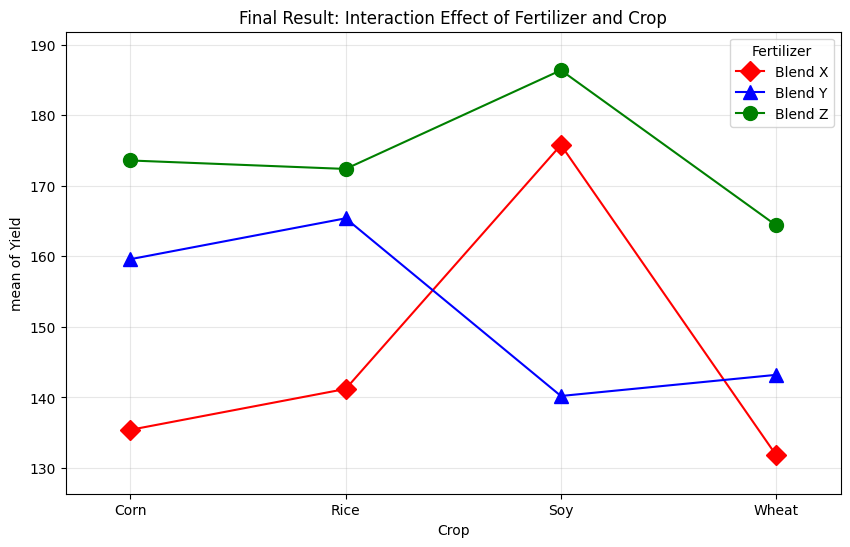

In [5]:
print("="*40)
print("       TWO-WAY ANOVA RESULTS")
print("="*40)

model = ols('Yield ~ C(Fertilizer) + C(Crop) + C(Fertilizer):C(Crop)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table['eta_sq'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
print(anova_table[['sum_sq', 'df', 'F', 'PR(>F)', 'eta_sq']])

print("\n" + "="*40)
print("       POST-HOC ANALYSIS (TUKEY HSD)")
print("="*40)

df['Group'] = df['Fertilizer'] + " + " + df['Crop']
tukey = pairwise_tukeyhsd(endog=df['Yield'], groups=df['Group'], alpha=0.05)

tukey_data = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
sig_diffs = tukey_data[tukey_data['reject'] == True]

print(f"Number of significant pairwise differences: {len(sig_diffs)}")
print("Top 5 most significant differences (by p-adj):")
print(sig_diffs.sort_values(by='p-adj').head(5)[['group1', 'group2', 'meandiff', 'p-adj']])

fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(x=df['Crop'], trace=df['Fertilizer'], response=df['Yield'], 
                 colors=['red', 'blue', 'green'], markers=['D', '^', 'o'], ms=10, ax=ax)
plt.title('Final Result: Interaction Effect of Fertilizer and Crop')
plt.grid(True, alpha=0.3)
plt.show()

## Reporting


    
<p style="text-align: justify; text-indent: 50px;">
A two-way analysis of variance (ANOVA) was conducted to examine the effect of fertilizer type (Blend X, Blend Y, Blend Z) and crop type (Wheat, Corn, Soy, Rice) on crop yield.
</p>

<p style="text-align: justify; text-indent: 50px;">
Prior to analysis, statistical assumptions were verified. Visual inspection of histograms and boxplots confirmed that the dependent variable (Yield) was continuous and that there were no extreme outliers that significantly skewed the results. A Shapiro-Wilk test was conducted for each group combination, and all groups indicated normal distribution ($p > .05$). Levene’s test for equality of variances indicated that the assumption of homogeneity of variance was met, $F(11, 48) = 0.67, p = .755$.
</p>

<p style="text-align: justify; text-indent: 50px;">
The analysis revealed a statistically significant interaction effect between fertilizer type and crop type on yield, $F(6, 48) = 2.35, p = .046, \eta_p^2 = .23$. This indicates that the effect of the fertilizer on yield is dependent on the crop it is applied to.
</p>

<p style="text-align: justify; text-indent: 50px;">
There was also a significant main effect of fertilizer type, $F(2, 48) = 9.93, p < .001, \eta_p^2 = .29$, indicating that fertilizer choice alone explains approximately 29% of the variance in yield. However, the main effect of crop type was not statistically significant, $F(3, 48) = 2.57, p = .065$.
</p>

<p style="text-align: justify; text-indent: 50px;">
Because the interaction effect was significant, simple main effects were analyzed using Tukey’s HSD post-hoc comparisons. The analysis indicated that Blend Z produced significantly higher yields for Soy ($M = 186.40, SD = 14.88$) compared to Blend Y ($M = 140.20, SD = 12.91$) and Blend X ($M = 175.80, SD = 16.75$). However, for Rice, there was no significant difference between the performance of Blend Y and Blend Z.
</p>

<p style="text-align: justify; text-indent: 50px;">
The null hypothesis regarding the interaction effect is rejected. The data suggests that while Blend Z is generally a high-performing fertilizer, its superiority is conditional. It is highly effective for Soy and Corn, but for crops like Rice, Blend Y is a statistically comparable alternative. Therefore, fertilizer recommendations should be tailored to the specific crop type to maximize yield.
</p>
    
